In [1]:
!pip install spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 17 kB/s 
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58761 sha256=6f4077fd985a95ed226692998281445d7793c99027464ce6b234b7d0e5526eb6
  Stored in directory: /root/.cache/pip/wheels/4e/0e/f1/164619f9920fb447d294afaae11a7715bd442ded7225953d72
Successfully built spark


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 53.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=2135c93109d33ed7f18ab77de2ef3c2bb5a8547c642801498a45676f23e74e49
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
#from pyspark.sql.functions import *
from pyspark.sql import functions as func
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Python Spark").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_annual_co2 = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/annual-co2-emissions-per-country.csv', inferSchema='true')

df_annual_death = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/annual-number-of-deaths-by-world-region.csv', inferSchema='true')

df_pib = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/gdp(pib)-per-capita-maddison-2020.csv', inferSchema='true')

df_population = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/population-world.csv', inferSchema='true')

df_nb_wo_clean_cooking_fuel = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/number-without-clean-cooking-fuel.csv', inferSchema='true')

df_pop_growth = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/population-growth-rate-vs-median-age.csv', inferSchema='true')

df_co2_target = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/net-zero-target-set.csv', inferSchema='true')

df_continent = spark.read\
    .option("header", "true")\
    .csv('/content/drive/MyDrive/Colab_Notebooks/Donnees_massives/Projet/Data/countryContinent.csv', inferSchema='true')



In [ ]:
df_annual_co2.printSchema()
df_annual_death.printSchema()
df_pib.printSchema()
df_population.printSchema()
df_nb_wo_clean_cooking_fuel.printSchema()
df_pop_growth.printSchema()
df_co2_target.printSchema()
df_continent.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Annual CO2 emissions: long (nullable = true)

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Deaths - sex: all - age: all - variant: estimates: integer (nullable = true)

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- GDP per capita: double (nullable = true)
 |-- 417485-annotations: string (nullable = true)

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Population - Sex: all - Age: all - Variant: estimates: long (nullable = true)
 |-- Population - Sex: all - Age: all - Variant: medium: long (nullable = true)
 |-- Population by broad age group - Sex: all - Age: 65+ - Variant: estimates: integer (nullable = true)
 |-- Population by broad age group - 

In [ ]:
df_annual_co2.show(1)
df_annual_death.show(1)
df_pib.show(1)
df_population.show(1)
df_nb_wo_clean_cooking_fuel.show(1)
df_pop_growth.show(1)
df_co2_target.show(1)
df_continent.show(1)

+-----------+----+----+--------------------+
|     Entity|Code|Year|Annual CO2 emissions|
+-----------+----+----+--------------------+
|Afghanistan| AFG|1949|               14656|
+-----------+----+----+--------------------+
only showing top 1 row

+-----------+----+----+-------------------------------------------------+
|     Entity|Code|Year|Deaths - sex: all - age: all - variant: estimates|
+-----------+----+----+-------------------------------------------------+
|Afghanistan| AFG|1950|                                           283668|
+-----------+----+----+-------------------------------------------------+
only showing top 1 row

+-----------+----+----+--------------+------------------+
|     Entity|Code|Year|GDP per capita|417485-annotations|
+-----------+----+----+--------------+------------------+
|Afghanistan| AFG|1950|        1156.0|              null|
+-----------+----+----+--------------+------------------+
only showing top 1 row

+-----------+----+----+--------------------

# Création des dataframes

In [ ]:
#Join global
df_all = df_annual_co2.join(df_annual_death, (df_annual_co2['Code'] == df_annual_death['Code']) \
             & (df_annual_co2['Year'] == df_annual_death['Year']), 'inner')\
         .select(df_annual_co2['Entity'].alias('Country'), df_annual_co2['Code'], df_annual_co2['Year'],\
             df_annual_co2['Annual CO2 emissions'].alias('Annual_CO2_emissions'),\
             df_annual_death['Deaths - sex: all - age: all - variant: estimates'].alias('Deaths'))\

df_all = df_all.join(df_pib, (df_all['Code'] == df_pib['Code']) \
             & (df_all['Year'] == df_pib['Year']), 'inner')\
         .select(df_all['Country'], df_all['Code'], df_all['Year'], df_all['Annual_CO2_emissions'],\
             df_all['Deaths'],df_pib['GDP per capita'].alias('PIB_per_capita'))

df_all = df_all.withColumn('PIB_per_capita', func.round(df_all['PIB_per_capita'],2)) # vire les décimales

df_all = df_all.join(df_population, (df_all['Code'] == df_population['Code']) \
             & (df_all['Year'] == df_population['Year']), 'inner')\
         .select(df_all['Country'], df_all['Code'], df_all['Year'], df_all['Annual_CO2_emissions'],\
             df_all['Deaths'],df_all['PIB_per_capita'], df_population['Population - Sex: all - Age: all - Variant: estimates'].alias('Population'))
         
df_all = df_all.join(df_pop_growth, (df_all['Code'] == df_pop_growth['Code']) \
             & (df_all['Year'] == df_pop_growth['Year']), 'inner')\
         .select(df_all['Country'], df_all['Code'], df_all['Year'], df_all['Annual_CO2_emissions'],\
             df_all['Deaths'],df_all['PIB_per_capita'], df_all['Population'],\
             df_pop_growth['Estimates, 1950 - 2020: Annually interpolated demographic indicators - Rate of natural increase (per 1,000 population)']\
             .alias('Rate_of_natural_population_increase'))

df_all = df_all.withColumn('Rate_of_natural_population_increase', func.round(df_all['Rate_of_natural_population_increase'],2)) # vire les décimales

df_all = df_all.join(df_co2_target, (df_all['Code'] == df_co2_target['Code']) \
             #& (df_all['Year'] == df_co2_target['Year'])
             , 'left')\
         .select(df_all['Country'], df_all['Code'], df_all['Year'], df_all['Annual_CO2_emissions'],\
             df_all['Deaths'],df_all['PIB_per_capita'], df_all['Population'], df_all['Rate_of_natural_population_increase'],\
             df_co2_target['Year'].alias('Net_zero_target'))
         
df_all = df_all.join(df_continent, (df_all['Code'] == df_continent['code_3']) #supprime les données 'World' \
             #& (df_all['Year'] == df_co2_target['Year'])
             , 'inner')\
         .select(df_all['Country'], df_all['Code'], df_all['Year'], df_all['Annual_CO2_emissions'],\
             df_all['Deaths'],df_all['PIB_per_capita'], df_all['Population'], df_all['Rate_of_natural_population_increase'],\
             df_all['Net_zero_target'], df_continent['continent'], df_continent['sub_region'] ) 


#Visu C02 World
#df_world_cO2 = df_annual_co2.filter(df_annual_co2.Entity == 'World' & df_annual_co2.Entity =='China')
#df_world_cO2 = df_annual_co2.filter(df_annual_co2.Entity.between("World", "China"))
df_world_cO2 = df_annual_co2.filter((df_annual_co2.Entity == 'World') | (df_annual_co2.Entity =='China')\
                                    | (df_annual_co2.Entity =='United States') | (df_annual_co2.Entity =='India')\
                                    | (df_annual_co2.Entity =='Russia'))

## Data cleaning

In [ ]:
#Suppression de la ligne avec Code = DMA (contient une valeur null)
cond = (df_all.Code == 'DMA')
df_all = df_all.filter(~cond)

#Pareil pour 'World'
cond = (df_all.Code == 'OWID_WRL')
df_all = df_all.filter(~cond)

In [ ]:
#On vérifie que les 'pays' Dominica et World ont bien disparu
df_all.filter(df_all.Code =='DMA').show(truncate=False)
df_all.filter(df_all.Code == 'OWID_WRL').show()#.select(countDistinct(df_all.Year)).show()

+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+----------+
|Country|Code|Year|Annual_CO2_emissions|Deaths|PIB_per_capita|Population|Rate_of_natural_population_increase|Net_zero_target|continent|sub_region|
+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+----------+
+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+----------+

+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+----------+
|Country|Code|Year|Annual_CO2_emissions|Deaths|PIB_per_capita|Population|Rate_of_natural_population_increase|Net_zero_target|continent|sub_region|
+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+--------

##Visu en interne : data

In [ ]:
#rechercher cb de pays sur 165 ont l'info pour une année donnée
annee = 2000
df_all.filter(df_all.Year==annee).select(func.count('Year')).collect()[0][0]

#à partir de l'année
#1950 : on a 117 pays avec toutes les infos
#1960 : on a 141 pays avec toutes les infos
#1970 : on a 144 pays avec toutes les infos
#1980 : on a 159 pays avec toutes les infos
#1990 : on a 163 pays avec toutes les infos
#2000 : tous les pays : 164

163

[Text(0, 0.5, 'Number of countries with data'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Number of countries for which we have data from one year')]

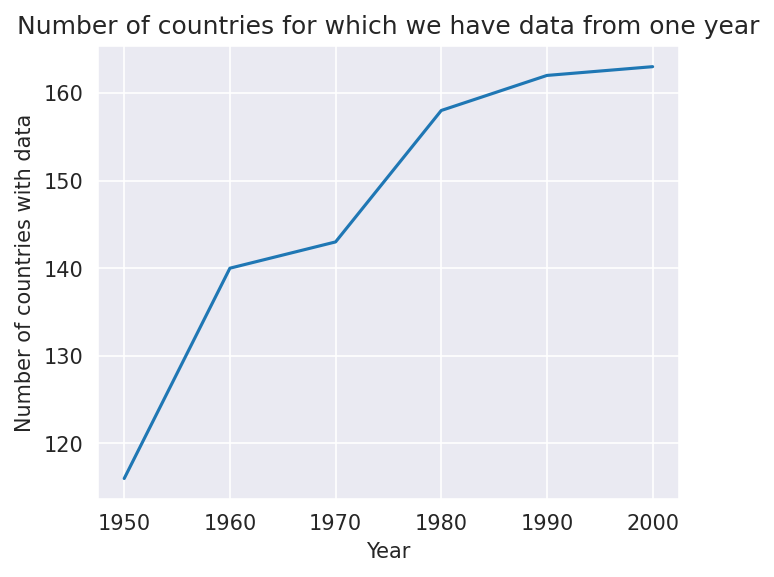

In [ ]:
#visualisation de l'évolution du nombre de pays pour lesquels nous avons toutes les informations#
fig = plt.figure(figsize=(5,4), dpi = 150)
annees = []
pays_w_infos = []
for annee in range(1950,2010,10):
  info = df_all.filter(df_all.Year==annee).select(func.count('Year')).collect()[0][0]
  annees.append(annee)
  pays_w_infos.append(info)

new_lst = [list(x) for x in zip(annees, pays_w_infos)]

columns = ["year","pays_w_infos"]
df_intro = spark.createDataFrame(data=new_lst, schema = columns)
#df_intro.printSchema()
#df_intro.show(truncate=False)

df_intro_pd = df_intro.toPandas()
sns.set_style("darkgrid")
sns.lineplot(data=df_intro_pd, x="year", y="pays_w_infos").set(title='Number of countries for which we have data from one year',\
                                                          ylabel='Number of countries with data', xlabel='Year')

In [ ]:
#nombre total de pays répértoriés
df_all.select(func.countDistinct('Country')).show(truncate=False)

+-----------------------+
|count(DISTINCT Country)|
+-----------------------+
|163                    |
+-----------------------+



In [ ]:
df_pop_growth.filter((df_pop_growth.Year=='2014')&(df_pop_growth.Code=='DMA')).show(truncate=False)

+------+----+----+----------------------------------------------------------------------------------------------------------------------+------------------------------------------+---------+
|Entity|Code|Year|Estimates, 1950 - 2020: Annually interpolated demographic indicators - Rate of natural increase (per 1,000 population)|UN Population Division (Median Age) (2017)|Continent|
+------+----+----+----------------------------------------------------------------------------------------------------------------------+------------------------------------------+---------+
+------+----+----+----------------------------------------------------------------------------------------------------------------------+------------------------------------------+---------+



In [ ]:
df_all.filter(df_all.Code == 'FRA').show(5, truncate=False)

+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+--------------+
|Country|Code|Year|Annual_CO2_emissions|Deaths|PIB_per_capita|Population|Rate_of_natural_population_increase|Net_zero_target|continent|sub_region    |
+-------+----+----+--------------------+------+--------------+----------+-----------------------------------+---------------+---------+--------------+
|France |FRA |1950|202428862           |533995|8266.0        |41842356  |0.66                               |2050           |Europe   |Western Europe|
|France |FRA |1951|228915868           |566424|8705.0        |42196660  |0.65                               |2050           |Europe   |Western Europe|
|France |FRA |1952|227188014           |525413|8869.0        |42542396  |0.64                               |2050           |Europe   |Western Europe|
|France |FRA |1953|214738732           |558275|9060.0        |42883300  |0.63                 

In [ ]:
#nombre de pays dont on a la donnée objectif 0 emissions
df_all.filter(df_all.Net_zero_target.isNotNull()).select(func.countDistinct("Country")).show(truncate=False)

+-----------------------+
|count(DISTINCT Country)|
+-----------------------+
|58                     |
+-----------------------+



Essayer de selectionner seulement les 50 premiers pays polluants pour la visu car bcp trop ne polluent pas et prennent de la place sur la visu pour rien

In [ ]:
df = df_all.filter(df_all.Year == 2018).orderBy(func.desc('Annual_CO2_emissions')).select(df_all.Country).head(50)
df

[Row(Country='China'),
 Row(Country='United States'),
 Row(Country='India'),
 Row(Country='Russia'),
 Row(Country='Japan'),
 Row(Country='Germany'),
 Row(Country='Iran'),
 Row(Country='South Korea'),
 Row(Country='Saudi Arabia'),
 Row(Country='Indonesia'),
 Row(Country='Canada'),
 Row(Country='Brazil'),
 Row(Country='South Africa'),
 Row(Country='Mexico'),
 Row(Country='Turkey'),
 Row(Country='Australia'),
 Row(Country='United Kingdom'),
 Row(Country='Italy'),
 Row(Country='Poland'),
 Row(Country='France'),
 Row(Country='Kazakhstan'),
 Row(Country='Taiwan'),
 Row(Country='Thailand'),
 Row(Country='Malaysia'),
 Row(Country='Spain'),
 Row(Country='Pakistan'),
 Row(Country='Ukraine'),
 Row(Country='Egypt'),
 Row(Country='Vietnam'),
 Row(Country='Iraq'),
 Row(Country='Argentina'),
 Row(Country='Algeria'),
 Row(Country='Netherlands'),
 Row(Country='United Arab Emirates'),
 Row(Country='Philippines'),
 Row(Country='Nigeria'),
 Row(Country='Venezuela'),
 Row(Country='Uzbekistan'),
 Row(Countr

In [ ]:
#Transformation df vers pandas pour visu
df_all_pd = df_all.toPandas() #df plein
df_world_cO2_pd = df_world_cO2.toPandas()
#df_all_2000_pd = df_all_2000.toPandas() #df test avec année min selectionnée au dessus

##Visu 1 : World C02 emission

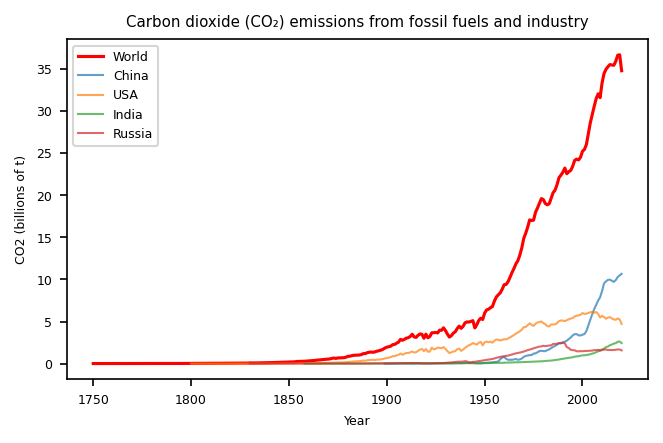

In [ ]:
plt.rcParams.update({'font.size': 6})
fig = plt.figure(figsize=(5,3), dpi=(150))

x_world = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'World']['Year']
y_world = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'World']['Annual CO2 emissions']

x_china = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'China']['Year']
y_china = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'China']['Annual CO2 emissions']

x_usa = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'United States']['Year']
y_usa = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'United States']['Annual CO2 emissions']

x_india = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'India']['Year']
y_india = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'India']['Annual CO2 emissions']

x_russia = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'Russia']['Year']
y_russia = df_world_cO2_pd[df_world_cO2_pd['Entity'] == 'Russia']['Annual CO2 emissions']

plt.plot(x_world, y_world/1000000000, label = 'World', color = 'r', linewidth=1.5)
plt.plot(x_china, y_china/1000000000, label = 'China', linewidth=1, alpha=0.7)
plt.plot(x_usa, y_usa/1000000000, label = 'USA', linewidth=1, alpha=0.7)
plt.plot(x_india, y_india/1000000000, label = 'India', linewidth=1, alpha=0.7)
plt.plot(x_russia, y_russia/1000000000, label = 'Russia', linewidth=1, alpha=0.7)

plt.ylabel('CO2 (billions of t)')
plt.xlabel('Year')


plt.title('Carbon dioxide (CO₂) emissions from fossil fuels and industry')

#plt.ylim([0, 5]) #placer des limites d'axes pour voir plus en détails sur une période
#plt.xlim([1750, 1950])
plt.legend()
plt.show()

In [ ]:
#selection des colonnes uniquement utilisées pour voir si ça marche mieux mais tester sans ça
df_all_pd['Year'] = df_all_pd['Year'].astype('int')
df_all_pd['Year'] = df_all_pd['Year'].astype('category')
#df_all_pd = df_all_pd[["Country", "Year", "Annual_CO2_emissions"]]

In [ ]:
df_all_pd.dtypes

Country                                  object
Code                                     object
Year                                   category
Annual_CO2_emissions                      int64
Deaths                                    int32
PIB_per_capita                          float64
Population                                int64
Rate_of_natural_population_increase     float64
Net_zero_target                         float64
dtype: object

In [ ]:
len(df_all_pd)

10415

In [ ]:
len(df_all_pd['Country'].unique())

163

##Visu 2 = Emissions C02 pour les N pays les plus polluants

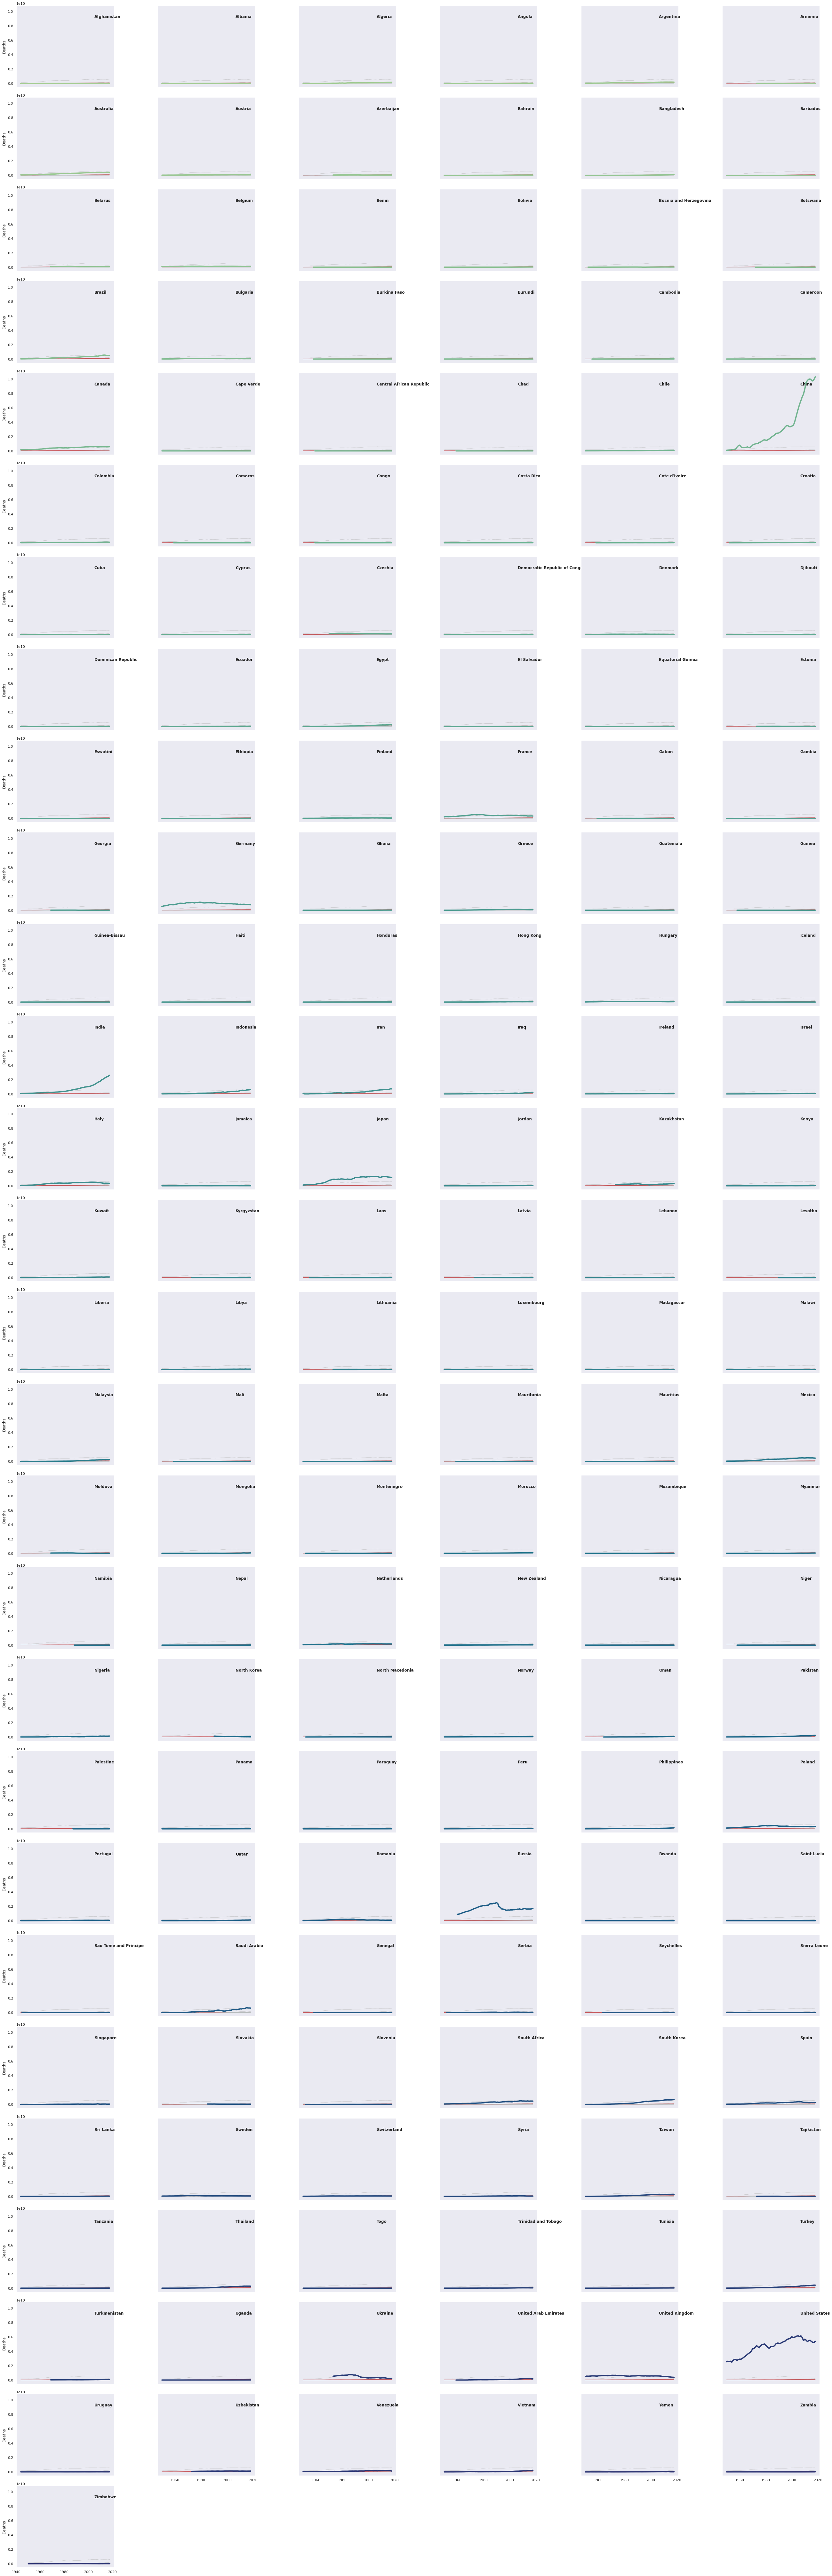

In [ ]:
sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_all_pd,
    x="Year", y="Annual_CO2_emissions", col="Country", hue="Country",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=6, height=4, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_test_pd, x="Year", y="Annual_CO2_emissions", units="Country",
        estimator=None, color="0.7", linewidth=0.5, ax=ax,
    )

    sns.lineplot(
    data=df_test_pd, x="Year", y="Annual_CO2_emissions",
    estimator=np.mean, color="r", linewidth=1.5, ax=ax, ci=None
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Deaths")
g.tight_layout()

## Test visu sur nombre de pays limité avant d'appliquer sur all (à supprimer une fois all fonctionnel)

In [ ]:
n = input("Please enter number n of most polluting countries...:\n")
year = input("...in the year (1950 - 2020) ? :\n")

df_test_pd = df_all_pd.copy()
df_test_list_pd = df_test_pd[df_test_pd['Year']==year].sort_values(['Annual_CO2_emissions'], ascending=False).head(n) #on classe les pays les plus polluants en 2018

#liste contenant seulement n pays, au hasard

#c_list = list(set(df_test_pd['Country'].tolist()))
c_list = df_test_list_pd['Country'].tolist()
#c_list = c_list[:n]
#len(c_list)

#on prend le tableau test avec seulement les pays étant dans la liste
df_test_pd = df_test_pd[df_test_pd['Country'].isin(c_list)]
#df_all_2000_pd = df_all_2000_pd[["Country", "Year", "Annual_CO2_emissions"]]

df_test_pd.dtypes

Please enter number n of most polluting countries...:
7
...in the year (1950 - 2020) ? :
1950


TypeError: ignored

In [ ]:
year = input("...in the year (1950 - 2020) ? :\n")

type(year)

...in the year (1950 - 2020) ? :
2018


str

In [ ]:
df_test_pd = df_test_pd.sort_values('Annual_CO2_emissions', ascending = False)
df_test_pd

In [ ]:
print(c_list)
print(len(df_test_pd['Country'].unique()))

['China', 'United States', 'India', 'Russia', 'Japan', 'Germany', 'Iran', 'South Korea', 'Saudi Arabia', 'Indonesia', 'Canada', 'Brazil', 'South Africa', 'Mexico', 'Turkey', 'Australia', 'United Kingdom', 'Italy', 'Poland', 'France']
20


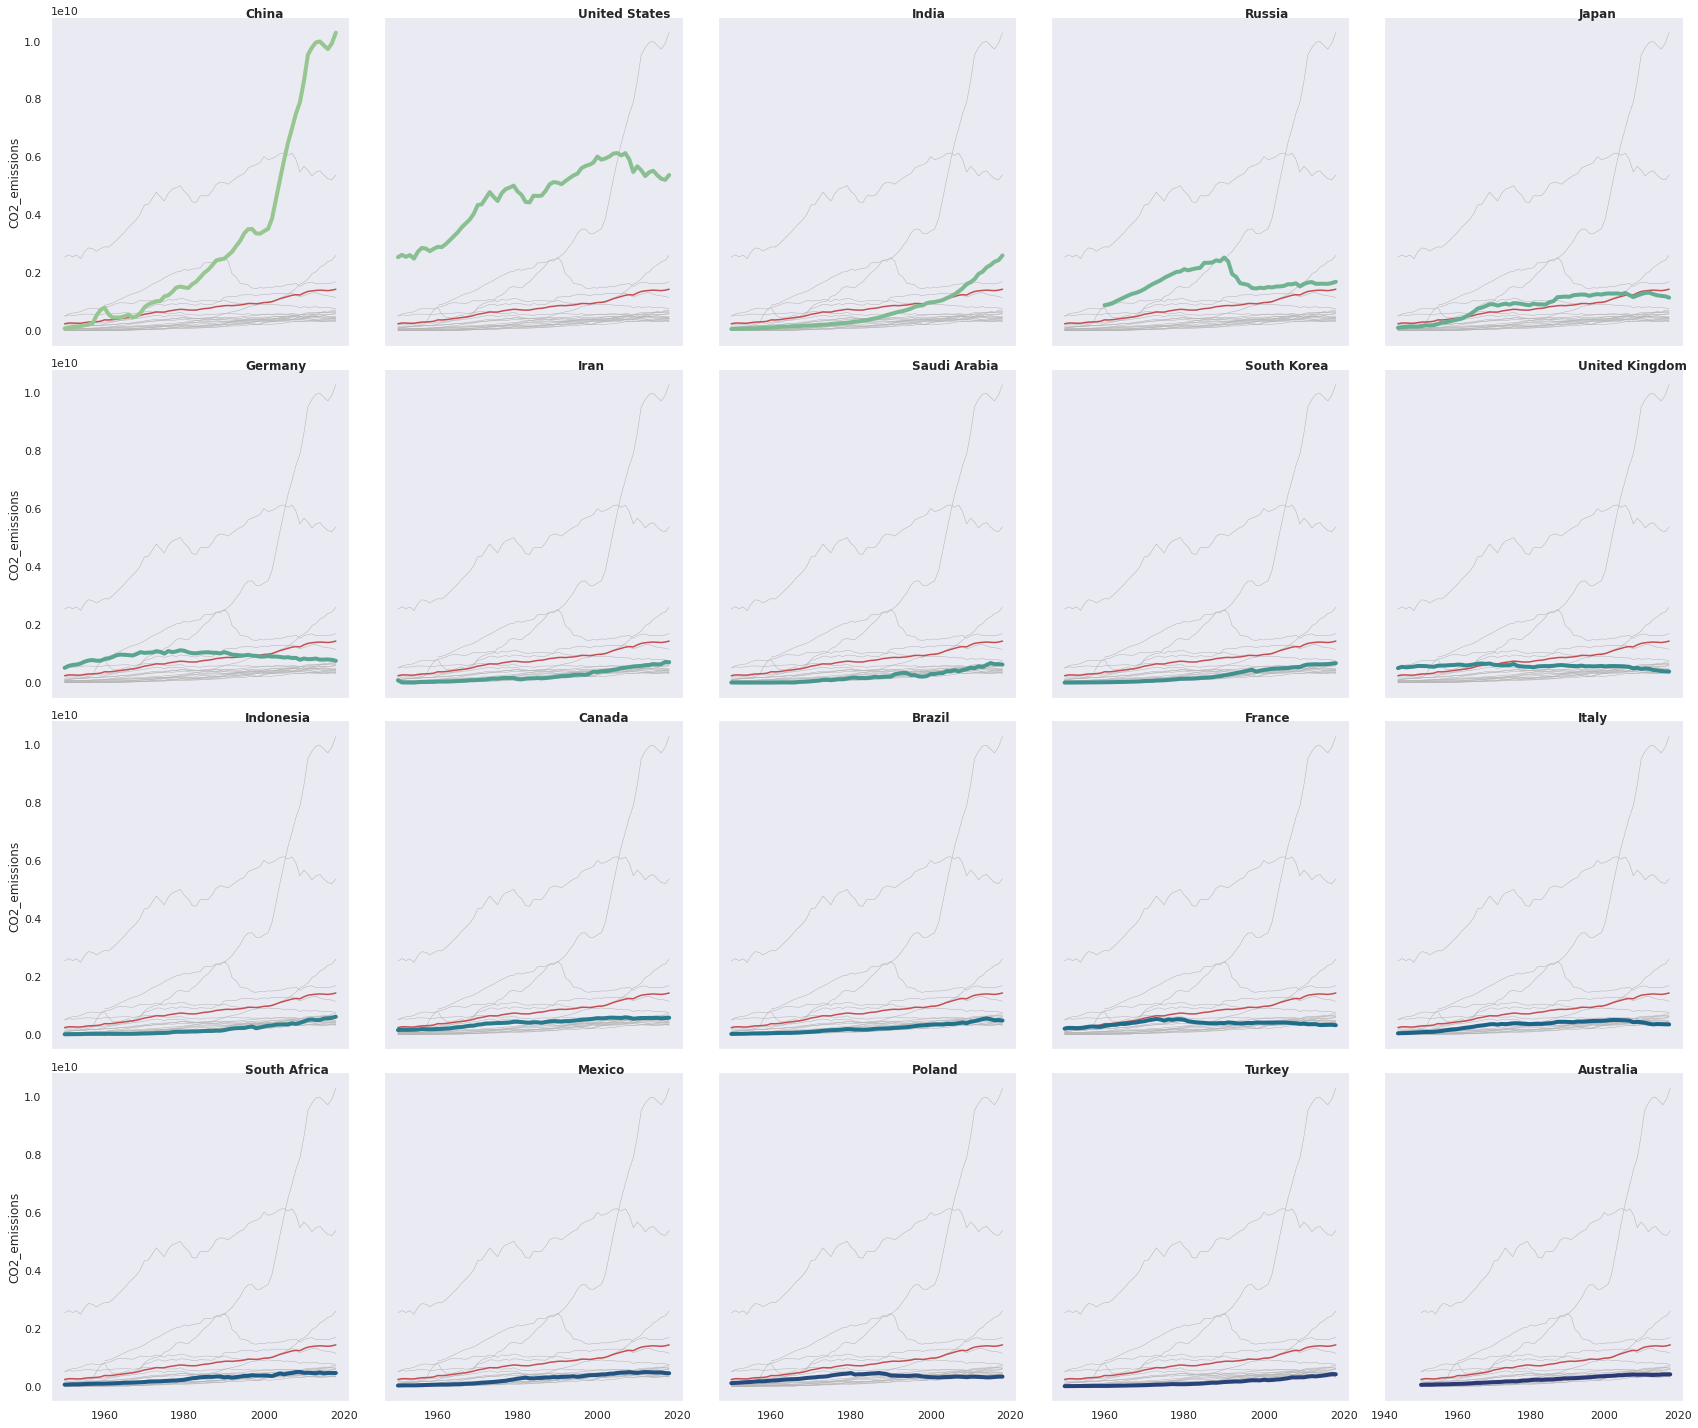

In [ ]:


sns.set_theme(style="dark")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_test_pd,
    x="Year", y="Annual_CO2_emissions", col="Country", hue="Country",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=5, aspect=.95, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.65, 1, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=df_test_pd, x="Year", y="Annual_CO2_emissions", units="Country",
        estimator=None, color="0.7", linewidth=0.5, ax=ax,
    )

    sns.lineplot(
    data=df_test_pd, x="Year", y="Annual_CO2_emissions",
    estimator=np.mean, color="r", linewidth=1.5, ax=ax, ci=None
    )


# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "CO2_emissions")
g.tight_layout()